<a href="https://colab.research.google.com/github/MeusEstudos/RedesNeuraisFFNN/blob/main/Aprendizagem_de_m%C3%A1quina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REDE NEURAL COM PREDIÇÕES DE VOLUME ÚTIL DO RESERVATÓRIO DE FUNIL (RJ) BASEADO EM VARIÁVEIS CLIMÁTICAS

## 1 - Importação das bibliotecas

In [ ]:
# Importação dos arquivos do seu Google Drive pelo Colab - https://colab.research.google.com/notebooks/io.ipynb 
from google.colab import drive
drive.mount('/content/drive')

# Álgebra linear https://numpy.org/
import numpy as np

# Processamento/manipulação dos dados https://pandas.pydata.org/
import pandas as pd

# Gráficos https://matplotlib.org/
import matplotlib.pyplot as plt

# Biblioteca Python para machine learning https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split # Irá dividir o dataset em dois conjuntos: treino e teste
from sklearn.preprocessing import StandardScaler, MinMaxScaler # escalonamento dos dados
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score # métricas

# Código aberto para machine learning com API do keras, onde este é uma biblioteca de rede neural em Python https://www.tensorflow.org/guide/keras?hl=pt-br
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Nadam

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 - Preparando o dataframe para iniciar a aprendizagem de máquina

- df_estacao_reservatorio_renomeado

In [ ]:
# lendo o arquivo
df_estacao_reservatorio = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/TCC_PUC-Minas/Dados/df_estacao_reservatorio.xlsx") 
df_estacao_reservatorio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5892 entries, 0 to 5891
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    5892 non-null   datetime64[ns]
 1   evap    5892 non-null   float64       
 2   inso    5892 non-null   float64       
 3   prec    5892 non-null   float64       
 4   temp    5892 non-null   float64       
 5   umid    5892 non-null   float64       
 6   vent    5892 non-null   int64         
 7   volu    5892 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 368.4 KB


In [ ]:
# conversão da data para um formato que a machine learning compreenda com data unix
df_estacao_reservatorio["DataUnix"] = df_estacao_reservatorio["data"].values.astype(np.int64) // 10 ** 9
df_estacao_reservatorio

,data,evap,inso,prec,temp,umid,vent,volu,DataUnix
0,1993-01-04,0.0,0.2,1.2,23.32,80.75,0,77.40,726105600
1,1993-02-04,1.5,0.1,0.0,21.92,93.75,0,78.06,728784000
2,1993-03-04,0.8,1.5,5.7,23.16,78.00,1266667,78.22,731203200
3,1993-04-04,1.3,8.2,0.0,23.96,76.75,1366667,78.22,733881600
4,1993-05-04,1.5,7.8,28.6,23.84,77.75,0,78.39,736473600
...,...,...,...,...,...,...,...,...,...
5887,2017-08-28,5.4,10.6,0.0,18.54,71.50,154332,26.73,1503878400
5888,2017-09-30,4.3,0.0,23.8,19.12,97.25,0,14.81,1506729600
5889,2017-11-14,8.9,12.2,0.0,22.06,55.00,0,26.38,1510617600
5890,2017-11-17,9.5,9.0,0.0,24.16,68.75,0,24.77,1510876800


In [ ]:
# retirando a coluna data
df_estacao_reservatorio_removido = df_estacao_reservatorio.drop(['data'], axis=1)
df_estacao_reservatorio_removido

,evap,inso,prec,temp,umid,vent,volu,DataUnix
0,0.0,0.2,1.2,23.32,80.75,0,77.40,726105600
1,1.5,0.1,0.0,21.92,93.75,0,78.06,728784000
2,0.8,1.5,5.7,23.16,78.00,1266667,78.22,731203200
3,1.3,8.2,0.0,23.96,76.75,1366667,78.22,733881600
4,1.5,7.8,28.6,23.84,77.75,0,78.39,736473600
...,...,...,...,...,...,...,...,...
5887,5.4,10.6,0.0,18.54,71.50,154332,26.73,1503878400
5888,4.3,0.0,23.8,19.12,97.25,0,14.81,1506729600
5889,8.9,12.2,0.0,22.06,55.00,0,26.38,1510617600
5890,9.5,9.0,0.0,24.16,68.75,0,24.77,1510876800


In [ ]:
# renomear coluna
df_estacao_reservatorio_renomeado = df_estacao_reservatorio_removido.rename(columns={'DataUnix': 'data'})
df_estacao_reservatorio_renomeado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5892 entries, 0 to 5891
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   evap    5892 non-null   float64
 1   inso    5892 non-null   float64
 2   prec    5892 non-null   float64
 3   temp    5892 non-null   float64
 4   umid    5892 non-null   float64
 5   vent    5892 non-null   int64  
 6   volu    5892 non-null   float64
 7   data    5892 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 368.4 KB


In [ ]:
# listando as colunas do dataframe para coletá-los facilmente para o próximo passo
list(df_estacao_reservatorio_renomeado.columns)

['evap', 'inso', 'prec', 'temp', 'umid', 'vent', 'volu', 'data']

In [ ]:
# VARIÁVEL X (em maiúsculo), o values transforma os valores em um array do numpy
X = (df_estacao_reservatorio_renomeado[['evap', 'inso', 'prec', 'temp', 'umid', 'vent', 'data']]).values
X

array([[0.0000000e+00, 2.0000000e-01, 1.2000000e+00, ..., 8.0750000e+01,
        0.0000000e+00, 7.2610560e+08],
       [1.5000000e+00, 1.0000000e-01, 0.0000000e+00, ..., 9.3750000e+01,
        0.0000000e+00, 7.2878400e+08],
       [8.0000000e-01, 1.5000000e+00, 5.7000000e+00, ..., 7.8000000e+01,
        1.2666670e+06, 7.3120320e+08],
       ...,
       [8.9000000e+00, 1.2200000e+01, 0.0000000e+00, ..., 5.5000000e+01,
        0.0000000e+00, 1.5106176e+09],
       [9.5000000e+00, 9.0000000e+00, 0.0000000e+00, ..., 6.8750000e+01,
        0.0000000e+00, 1.5108768e+09],
       [2.7000000e+00, 3.2000000e+00, 2.4000000e+00, ..., 8.3750000e+01,
        0.0000000e+00, 1.4919552e+09]])

In [ ]:
# VARIÁVEL y (em minúsculo), o values transforma os valores em um array do numpy
y = df_estacao_reservatorio_renomeado['volu'].values
y

array([77.4 , 78.06, 78.22, ..., 26.38, 24.77, 30.68])

In [ ]:
# definindo o tamanho da amostra separando-os nas 4 variáveis (X_treino, X_teste, y_treino, y_teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# exibindo a quantidade de cada variável após a divisão da amosta
print("Quantidade de dados para o treino do X: ", len(X_treino))
print("Quantidade de dados para o teste do X: ", len(X_teste))
print("Quantidade de dados para o treino do y: ", len(y_treino))
print("Quantidade de dados para o treino do y: ", len(y_teste))

Quantidade de dados para o treino do X:  4419
Quantidade de dados para o teste do X:  1473
Quantidade de dados para o treino do y:  4419
Quantidade de dados para o treino do y:  1473


In [ ]:
# escalonamento dos dados, instanciando o StandardScaler deixando-o pronto para ser utilizado
escalador = StandardScaler()

In [ ]:
# padronizar o X_treino, normalizando com o fit_transform, com valores entre 0 e 1 para diminuir os ruídos e convergência na rede neural
X_treino = escalador.fit_transform(X_treino)
X_treino

array([[ 0.61199678, -0.65179519, -0.39988599, ...,  0.90700409,
        -0.82557428,  1.51293483],
       [-0.91209034,  0.19588704, -0.39016268, ...,  0.44310983,
         0.30058983, -1.52892398],
       [-0.70187143, -1.47122134,  0.33908611, ...,  0.83741995,
         0.0542408 ,  0.38724764],
       ...,
       [ 0.71710623,  0.84577675, -0.39988599, ..., -0.73982054,
         1.14521264,  1.32963409],
       [-1.06975452, -0.199698  ,  1.8170303 , ...,  0.07199442,
         0.89886361,  1.40813093],
       [-0.96464507, -1.49947741, -0.39988599, ...,  1.90437675,
        -0.82557428, -1.29003899]])

In [ ]:
# padronizar o X_teste, normalizando com o transform
# as variáveis y_treino e y_teste não serão normalizadas, pois esses refletem a realidade do aprendizado da rede neural ao realizar seu teste
X_teste = escalador.transform(X_teste)
X_teste

array([[ 1.71564606, -1.52773349,  0.66967889, ...,  0.97658823,
        -0.82556055,  1.39964479],
       [ 0.34922314, -0.68005126,  0.06683323, ...,  0.83741995,
        -0.01614373,  1.19512868],
       [-0.80698088, -1.0756363 , -0.39988599, ...,  0.65186224,
        -0.01614373, -0.28527938],
       ...,
       [-0.85953561, -0.36923444, -0.39988599, ...,  0.46630454,
        -0.82556161, -1.41139087],
       [-1.06975452, -0.82133163, -0.21514297, ...,  0.99978294,
        -0.82557428, -0.69303866],
       [-0.70187143, -1.44296527, -0.35126941, ...,  1.11575651,
        -0.26249275, -1.44363822]])

In [ ]:
# a rede neural passa por um processo de convergência, exibindo o momento do seu ponto ótimo
parar_rede_neural = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=21)

# o learning_rate é a velocidade com que a rede neural aprende, quanto menor o número mais lento é seu aprendizado
velocidade_aprendizagem = Nadam(learning_rate=0.0003) 

## 3 - iniciando a aprendizagem de máquina com a rede neural FeedForward

A rede neural FeedForward irá prever o volume útil com base nas variáveis climáticas

In [ ]:
# instanciando o modelo senquencial, que é a rede neural FeedForward, onde iniciará a aprendizagem de máquina
modelo = Sequential()

# 1ª camada é a camada de entrada
# que é a mesma QTD de variáveis do X_treino ('evap', 'inso', 'prec', 'temp', 'umid', 'vent', 'data') para a QTD de neurônios, sendo portanto 7 neurônios 
modelo.add(Dense(7, activation="relu"))

# camada oculta
modelo.add(Dense(666, activation="relu")) # 2ª camada com 666 neurônios

# a última camada é a de saída
# é a mesma QTD de variáveis do y_treino, o volume útil 
modelo.add(Dense(1)) 

# compila o modelo 
# obtém uma média entre o valor previsto e o real com o mse
modelo.compile(optimizer=velocidade_aprendizagem, loss="mse")

In [ ]:
# o fit estará realizando o ajuste do modelo neural, usando a variável x do X_treino e y de y_treino
# aqui ocorre o treino e o teste da rede neural
modelo.fit(x=X_treino, y=y_treino, epochs=2500, validation_data=(X_teste, y_teste), callbacks=[parar_rede_neural])

Epoch 1/2500
139/139 [==============================] - 1s 3ms/step - loss: 2892.3606 - val_loss: 2390.4480
Epoch 2/2500
139/139 [==============================] - 0s 2ms/step - loss: 1834.6471 - val_loss: 1325.7145
Epoch 3/2500
139/139 [==============================] - 0s 3ms/step - loss: 1145.9307 - val_loss: 989.9532
Epoch 4/2500
139/139 [==============================] - 0s 2ms/step - loss: 926.5819 - val_loss: 851.9927
Epoch 5/2500
139/139 [==============================] - 0s 2ms/step - loss: 818.1442 - val_loss: 769.8351
Epoch 6/2500
139/139 [==============================] - 0s 2ms/step - loss: 751.9915 - val_loss: 717.0583
Epoch 7/2500
139/139 [==============================] - 0s 2ms/step - loss: 708.5491 - val_loss: 680.2858
Epoch 8/2500
139/139 [==============================] - 0s 2ms/step - loss: 676.9805 - val_loss: 651.8678
Epoch 9/2500
139/139 [==============================] - 0s 3ms/step - loss: 652.7467 - val_loss: 629.1462
Epoch 10/2500
139/139 [==================

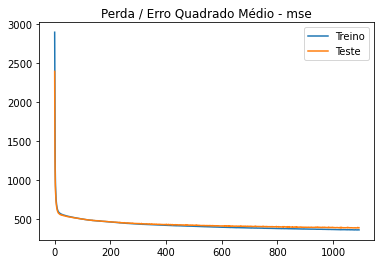

In [ ]:
# visualizar a convergência da rede neural
# perdas = pd.DataFrame(modelo.history.history)
# perdas.plot()

perdas_loss = pd.DataFrame(modelo.history.history['loss'])
perdas_val_loss = pd.DataFrame(modelo.history.history['val_loss'])

perdas_loss_plot = plt.plot(perdas_loss.index, perdas_loss[0], label='Treino')
perdas_val_loss_plot = plt.plot(perdas_val_loss.index, perdas_val_loss[0], label='Teste')

plt.title('Perda / Erro Quadrado Médio - mse')
plt.legend()
plt.show()

In [ ]:
# valores que a rede está prevendo
previsoes = modelo.predict(X_teste)
previsoes

array([[38.817844],
       [52.617275],
       [20.334005],
       ...,
       [59.906822],
       [49.801525],
       [55.38109 ]], dtype=float32)

In [ ]:
# a previsão da rede versus os valores corretos que vc já sabe, mas não deixou a rede saber
df = pd.DataFrame(previsoes, y_teste)
df_resetada = df.reset_index()
df_resetada_renomeada = df_resetada.rename(columns={"index": "Previsão da rede", 0: "Valores corretos"})
df_resetada_renomeada

,Previsão da rede,Valores corretos
0,45.38,38.817844
1,50.17,52.617275
2,12.20,20.334005
3,46.03,65.042511
4,47.21,61.835258
...,...,...
1468,45.33,38.289410
1469,14.16,26.554461
1470,27.05,59.906822
1471,62.68,49.801525


In [ ]:
# média dos dados que a rede está prevendo, comparando os dois: loss e val_loss
mean_squared_error(y_teste, previsoes)

384.1688587524638

In [ ]:
# é o erro ao quadrado, este número é a média de erro na coluna y
np.sqrt(mean_squared_error(y_teste, previsoes))

19.600225987280446

In [ ]:
# eficiência da rede neural, onde o número 0.0145 seria apenas 1% de eficiência
explained_variance_score(y_teste, previsoes)

0.3675539056634952

### Marina Micas Jardim


---

###### Trabalho de Conclusão de Curso apresentado ao Curso de Especialização em Inteligência Artificial e Aprendizado de Máquina, como requisito parcial à obtenção do título de Especialista.
